In [1]:
%load_ext autoreload
import trafpy.generator as tpg
import config

Demand config file imported.


## Node Distributions

In [ ]:
%autoreload
_ = tpg.gen_uniform_node_dist(config.ENDPOINT_LABELS, show_fig=True, print_data=True)
_ = tpg.gen_uniform_multinomial_exp_node_dist(config.ENDPOINT_LABELS, show_fig=True, print_data=True)
_ = tpg.gen_multimodal_node_dist(config.ENDPOINT_LABELS, show_fig=True, print_data=True)
_ = tpg.gen_multimodal_node_pair_dist(config.ENDPOINT_LABELS, show_fig=True, print_data=True)

## Value Distributions

In [ ]:
%autoreload
_ = tpg.gen_uniform_val_dist(min_val=0,
                             max_val=100,
                             round_to_nearest=1,
                             show_fig=True,
                             print_data=False,
                             num_bins=101)

_ = tpg.gen_multimodal_val_dist(min_val=10,
                               max_val=7000,
                               locations=[20,4000],
                               skews=[6,-1],
                               scales=[150,1500],
                               num_skew_samples=[10000,650],
                               bg_factor=0.05,
                               show_fig=True,
                               print_data=False,
                               logscale=True,
                               xlim=[10,10000],
                               num_bins=18)

_ = tpg.gen_named_val_dist(dist='weibull',
                          params={'_alpha': 1.4, '_lambda': 7000},
                          rand_var_name='Flow Size (Bytes)',
                          show_fig=True,
                          print_data=False,
                          logscale=True,
                          num_bins=100,
                          xlim=[1e2,1e12])

## Generating Job-Centric Demand Data

In [ ]:
%autoreload
# NETWORK
net = tpg.gen_arbitrary_network(ep_label=config.ENDPOINT_LABEL, num_eps=len(config.ENDPOINT_LABELS), server_to_rack_channel_capacity=500)


# UNIFORM
node_dist, _ = tpg.gen_uniform_node_dist(config.ENDPOINT_LABELS, show_fig=True, print_data=False)
network_load_config = {'network_rate_capacity': net.graph['max_nw_capacity'], 
                       'ep_link_capacity': net.graph['ep_link_capacity'],
                       'target_load_fraction': 0.1}

# flow_size_dist, _ = tpg.gen_multimodal_val_dist(config.MIN_FLOW_SIZE,
#                                             config.MAX_FLOW_SIZE,
#                                             locations=[50],
#                                             skews=[0],
#                                             scales=[10],
#                                             num_skew_samples=[10000],
#                                             bg_factor=0,
#                                             round_to_nearest=10,
#                                             show_fig=True,
#                                             num_bins=34,
#                                             print_data=False)
flow_size_dist, _ = tpg.gen_uniform_val_dist(min_val=1,
                                         max_val=10,
                                         round_to_nearest=1,
                                         show_fig=True,
                                         print_data=False,
                                         num_bins=20)

# interarrival_time_dist, _ = tpg.gen_multimodal_val_dist(config.MIN_INTERARRIVAL,
#                                                     config.MAX_INTERARRIVAL,
#                                                     locations=[1, 1, 3000, 1, 1800000, 10000000],
#                                                     skews=[0, 100, -10, 10, 50, 6],
#                                                     scales=[0.1, 62, 2000, 7500, 3500000, 20000000],
#                                                     num_skew_samples=[800, 1000, 2000, 4000, 4000, 3000],
#                                                     bg_factor=0.025,
#                                                     round_to_nearest=1,
#                                                     show_fig=True,
#                                                     print_data=False)
interarrival_time_dist, _ = tpg.gen_uniform_val_dist(min_val=900,
                                                 max_val=1000,
                                                 round_to_nearest=10,
                                                 show_fig=True,
                                                 print_data=False,
                                                 num_bins=20)

# num_ops_dist, _ = tpg.gen_multimodal_val_dist(config.MIN_NUM_OPS,
#                                               config.MAX_NUM_OPS,
#                                               locations=[100],
#                                               skews=[0.05],
#                                               scales=[50],
#                                               num_skew_samples=[10000],
#                                               bg_factor=0.05,
#                                               round_to_nearest=10,
#                                               show_fig=True,
#                                               print_data=False)
num_ops_dist, _ = tpg.gen_uniform_val_dist(min_val=10,
                                                 max_val=30,
                                                 round_to_nearest=10,
                                                 show_fig=True,
                                                 print_data=False,
                                                 num_bins=20)


job_centric_demand_data = tpg.create_demand_data(min_num_demands=config.NUM_DEMANDS,
                                                 max_num_demands=None, # None
                                                eps=config.ENDPOINT_LABELS,
                                                node_dist=node_dist,
                                                flow_size_dist=flow_size_dist,
                                                interarrival_time_dist=interarrival_time_dist,
                                                num_ops_dist=num_ops_dist,
                                                c=config.C,
                                                jensen_shannon_distance_threshold=0.5,
                                                network_load_config=network_load_config,
                                                min_last_demand_arrival_time=300, # None
                                                use_multiprocessing=False,
                                                print_data=True)



# print('Job data:\n{}'.format(job_centric_demand_data))

jobs = list(job_centric_demand_data['job'][0:2])
# fig = tpg.draw_job_graphs(job_graphs=jobs,show_fig=True)

In [ ]:
%autoreload
demand = tpg.Demand(job_centric_demand_data, net.graph['endpoints'])
slots_dict = demand.get_slots_dict(slot_size=2)
print(slots_dict)

In [ ]:
%autoreload
jobs = list(job_centric_demand_data['job'][0:2])
fig = tpg.draw_job_graphs(job_graphs=jobs,show_fig=True)

## Generating Flow-Centric Demand Data

In [ ]:
%autoreload
from trafpy.generator import Demand, DemandPlotter
import numpy as np
import copy

# node_dist, _ = tpg.gen_uniform_node_dist(config.ENDPOINT_LABELS, show_fig=True, print_data=False)
# UNIVERSITY
net = tpg.gen_fat_tree(k=4, n=2, L=2, num_channels=1, server_to_rack_channel_capacity=500, rack_to_edge_channel_capacity=10000, edge_to_agg_channel_capacity=40000, agg_to_core_channel_capacity=40000, bidirectional_links=True)
num_skewed_nodes = int(0.2 * len(net.graph['endpoints'])) 
skewed_node_probs = [0.55/num_skewed_nodes for _ in range(num_skewed_nodes)]
racks_dict = net.graph['rack_to_ep_dict']
rack_prob_config = {'racks_dict': racks_dict, 'prob_inter_rack': 0.7}
node_dist, _ = tpg.gen_multimodal_node_dist(net.graph['endpoints'], rack_prob_config=rack_prob_config, num_skewed_nodes=num_skewed_nodes, skewed_node_probs=skewed_node_probs, show_fig=True, print_data=False)

net = tpg.gen_fat_tree(k=4, n=2, L=2, num_channels=1, server_to_rack_channel_capacity=500, rack_to_edge_channel_capacity=10000, edge_to_agg_channel_capacity=40000, agg_to_core_channel_capacity=40000, bidirectional_links=True)
racks_dict = net.graph['rack_to_ep_dict']
rack_prob_config = {'racks_dict': racks_dict, 'prob_inter_rack': 0.7}
# rack_prob_config = None
skewed_pairs = [['server_0', 'server_1'],
                ['server_1', 'server_2'],
               ['server_2', 'server_3'],
               ['server_3', 'server_4'],
               ['server_4', 'server_5'],
               ['server_5', 'server_6'],
               ['server_6', 'server_7']]
skewed_pair_probs = [1/len(skewed_pairs) for _ in range(len(skewed_pairs))]
node_dist, _ = tpg.gen_multimodal_node_pair_dist(net.graph['endpoints'], rack_prob_config=rack_prob_config, skewed_pairs=skewed_pairs, skewed_pair_probs=skewed_pair_probs, show_fig=True, print_data=False)


net = tpg.gen_fat_tree(k=4, n=2, L=2, num_channels=1, server_to_rack_channel_capacity=500, rack_to_edge_channel_capacity=10000, edge_to_agg_channel_capacity=40000, agg_to_core_channel_capacity=40000, bidirectional_links=True)
# racks_dict = net.graph['rack_to_ep_dict']
# rack_prob_config = {'racks_dict': racks_dict, 'prob_inter_rack': 0.7}
rack_prob_config = None
skewed_pairs = [['server_0', 'server_1'],
                ['server_1', 'server_2'],
               ['server_2', 'server_3'],
               ['server_3', 'server_4'],
               ['server_4', 'server_5'],
               ['server_5', 'server_6'],
               ['server_6', 'server_7']]
skewed_pair_probs = [1/len(skewed_pairs) for _ in range(len(skewed_pairs))]
node_dist, _ = tpg.gen_multimodal_node_pair_dist(net.graph['endpoints'], rack_prob_config=rack_prob_config, skewed_pairs=skewed_pairs, skewed_pair_probs=skewed_pair_probs, show_fig=True, print_data=False)






# flow_size_dist, _ = tpg.gen_named_val_dist(dist='lognormal',
#                                               params={'_mu': 7, '_sigma': 2.5},
#                                               min_val=1,
#                                               round_to_nearest=1,
#                                               show_fig=True,
#                                               logscale=True,
#                                               num_bins=32,
#                                               print_data=False)
flow_size_dist = tpg.gen_named_val_dist(dist='lognormal',
                                          params={'_mu': 7, '_sigma': 2.5},
                                          min_val=1,
                                          max_val=2e7,
                                          round_to_nearest=25,
                                          show_fig=False,
                                        
                                          print_data=False)
# flow_size_dist, _ = tpg.gen_multimodal_val_dist(config.MIN_FLOW_SIZE,
#                                             config.MAX_FLOW_SIZE,
#                                             locations=[50],
#                                             skews=[0],
#                                             scales=[10],
#                                             num_skew_samples=[10000],
#                                             bg_factor=0,
#                                             round_to_nearest=1,
#                                             show_fig=True,
#                                             num_bins=34,
#                                             print_data=False)

interarrival_time_dist, _ = tpg.gen_named_val_dist(dist='weibull',
                                                  params={'_alpha': 0.9, '_lambda': 6000},
                                                  min_val=1,
                                                  round_to_nearest=25,
                                                   show_fig=True,
                                                   print_data=False)
# interarrival_time_dist, _ = tpg.gen_named_val_dist(dist='lognormal',
#                                                params={'_mu': 7.4, '_sigma': 2},
#                                                show_fig=True,
#                                                print_data=False,
#                                                logscale=True,
#                                                num_bins=20,
#                                                xlim=[1e1,1e6])




In [ ]:
%autoreload


# JENSEN SHANNON DISTANCE TESTS

flow_sizes = tpg.gen_rand_vars_from_discretised_dist(unique_vars=list(flow_size_dist.keys()),
                                                     probabilities=list(flow_size_dist.values()),
                                                     num_demands=10,
                                                     jensen_shannon_distance_threshold=0.1,
                                                     show_fig=True,
                                                     logscale=True,
                                                     figsize=(3,2), #(4,3)
                                                     font_size=20,
                                                     xlabel='Size (B)')


# interarrival_times = tpg.gen_rand_vars_from_discretised_dist(unique_vars=list(interarrival_time_dist.keys()),
#                                                              probabilities=list(interarrival_time_dist.values()),
#                                                              num_demands=10,
#                                                              jensen_shannon_distance_threshold=0.1,
#                                                              show_fig=True,
#                                                              logscale=False,
#                                                              figsize=(3,2), #(4,3)
#                                                              font_size=20,
#                                                              xlabel='Time (\u03BCs)')

In [ ]:
%autoreload
for load in np.arange(0.1, 1.0, 0.1):
    network_load_config = {'network_rate_capacity': net.graph['max_nw_capacity'], 
                               'ep_link_capacity': net.graph['ep_link_capacity'],
                               'target_load_fraction': load,
                               'disable_timeouts': True}

    flow_centric_demand_data = tpg.create_demand_data(eps=config.ENDPOINT_LABELS,
                                                      node_dist=copy.deepcopy(node_dist),
                                                      flow_size_dist=flow_size_dist,
                                                      interarrival_time_dist=interarrival_time_dist,
                                                      network_load_config=network_load_config,
                                                      min_last_demand_arrival_time=None,
                                                      auto_node_dist_correction=True,
                                                      print_data=True)

    # print('Flow data:\n{}'.format(flow_centric_demand_data))
    demand = Demand(flow_centric_demand_data, net.graph['endpoints'])
    plotter = DemandPlotter(demand)
    plotter.plot_node_dist(eps=net.graph['endpoints'])
    plotter.plot_node_load_dists(eps=net.graph['endpoints'], ep_link_bandwidth=net.graph['ep_link_capacity'])

## Organise into Slots Dict

In [ ]:
# DO THIS INTERNALLY IN DEMAND OBJECT WHEN PASS DEMAND INTO ENV

# slot_size = 100000

# job_centric_slot_dict = tpg.construct_demand_slots_dict(demand_data=job_centric_demand_data,
#                                                        slot_size=slot_size)
# # print('\n\nJob slot dict:\n{}'.format(job_centric_slot_dict))


# flow_centric_slot_dict = tpg.construct_demand_slots_dict(demand_data=flow_centric_demand_data,
#                                                         slot_size=slot_size)
# # print('\n\nFlow slot dict:\n{}'.format(flow_centric_slot_dict))


## Save Demand Data

In [ ]:
%autoreload
tpg.pickle_data(data=flow_centric_demand_data,
               path_to_save='data/flow_centric_demand_data.pickle',
               overwrite=True,
               zip_data=True)

tpg.pickle_data(path_to_save='data/job_centric_demand_data.pickle',
               data=job_centric_demand_data,
               overwrite=True,
               zip_data=True)

## Load Demand Data

In [ ]:
%autoreload
flow_centric_demand_data = tpg.unpickle_data(path_to_load='data/flow_centric_demand_data.pickle',
                                             zip_data=True)
job_centric_demand_data = tpg.unpickle_data(path_to_load='data/job_centric_demand_data.pickle',
                                             zip_data=True)

## Plot Demand Data

In [ ]:
%autoreload
import trafpy.generator as tpg
import config

job_centric_demand_data = tpg.unpickle_data(path_to_load='data/job_centric_demand_data.pickle',
                                            zip_data=True)


dep_stats = tpg.get_job_demand_data_dependency_stats(job_centric_demand_data)

# get dependency stats
flow_sizes = []
for job_id in dep_stats.keys():
    for dep in dep_stats[job_id]:
        if dep['attr_dict']['dependency_type'] == 'data_dep' and dep['attr_dict']['flow_size'] != 0:
            flow_sizes.append(dep['attr_dict']['flow_size'])
# get job stats
num_ops = []
num_edges = []
for idx in range(len(job_centric_demand_data['job_id'])):
    establish = job_centric_demand_data['establish'][idx]
    if establish == 0:
        # take down, ignore
        pass
    else:
        # connection
        job = job_centric_demand_data['job'][idx]
        num_ops.append(job.number_of_nodes())
        num_edges.append(job.number_of_edges())
# use multiprocessing for graph diameters
diameters = tpg.calc_graph_diameters(job_centric_demand_data['job'],multiprocessing_type='pool')

# plot
_ = tpg.draw_job_graphs(job_centric_demand_data,show_fig=True)
_ = tpg.plot_val_dist(flow_sizes, 
                      show_fig=True,
                      rand_var_name='Flow Sizes',
                      num_bins=0)
_ = tpg.plot_val_dist(num_ops, 
                      show_fig=True,
                      rand_var_name='Num Ops',
                      num_bins=10)
_ = tpg.plot_val_dist(num_edges, 
                      show_fig=True,
                      rand_var_name='Num Edges',
                      num_bins=10)
_ = tpg.plot_val_dist(diameters, 
                      show_fig=True,
                      rand_var_name='Diameters',
                      num_bins=10)



# problem: last 2 bins/hists being combined into single bar so get peak and get one bar removed

## Pack Flows and Visualise Node Dist Adjustments Made by Flow Packer

<Figure size 640x480 with 0 Axes>

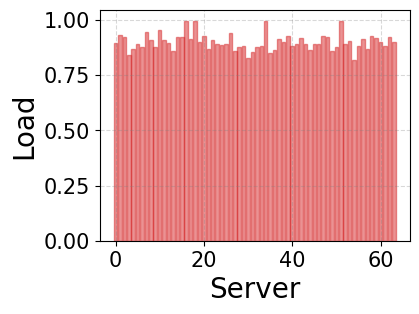

<Figure size 640x480 with 0 Axes>

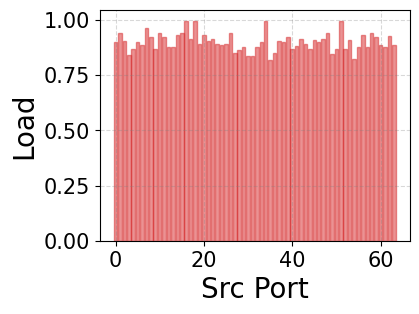

<Figure size 640x480 with 0 Axes>

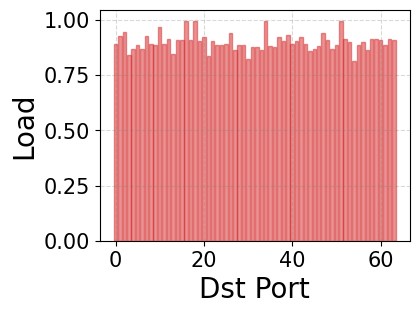

Exception: 

In [8]:
%autoreload
import time
from trafpy.generator import Demand, DemandPlotter
from trafpy.benchmarker import BenchmarkImporter




plotter.plot_node_load_dists(eps=net.graph['endpoints'], 
                                 ep_link_bandwidth=net.graph['ep_link_capacity'], 
                                 figsize=(4,3),
                                 font_size=20,
                                 show_fig=True)
raise Exception()


# set vars
N = 64
endpoints = [str(i) for i in range(N)]
min_last_demand_arrival_time = None 
jensen_shannon_distance_threshold = 0.9
min_num_demands = 10000
LOADS = [0.9]
# LOADS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# init network
net = tpg.gen_arbitrary_network(ep_label=None, num_eps=N, server_to_rack_channel_capacity=250)

# set dists
flow_size_dist = {1: 1}

interarrival_time_dist = {1: 1}

# node_dist = tpg.gen_multimodal_node_dist(eps=net.graph['endpoints'],
#                                          skewed_nodes=[],
#                                          skewed_node_probs=[],
#                                          show_fig=False,
#                                          num_skewed_nodes=int(len(endpoints)*0.05))
importer = BenchmarkImporter(benchmark_version='0.0.1', load_prev_dists=True)
benchmark_dists = importer.get_benchmark_dists(benchmark='skewed_nodes_sensitivity_0.05', racks_dict=None, eps=net.graph['endpoints'])
node_dist = benchmark_dists['node_dist']

# plot dists
tpg.plot_dict_scatter(_dict=interarrival_time_dist, marker_size=30, logscale=False, rand_var_name='Interarrival Time (us)', show_fig=True)
tpg.plot_dict_scatter(_dict=flow_size_dist, marker_size=30, logscale=True, rand_var_name='Flow Size (Bytes)', show_fig=True)
tpg.plot_node_dist(node_dist, 
                   plot_chord=False, 
                   font_size=20,
                   show_fig=True)



# gen demands
demands = []
for load in LOADS:
    print('\nGenerating load {}...'.format(load))
    
    start = time.time()
    
    network_load_config = {'network_rate_capacity': net.graph['max_nw_capacity'], 
                           'ep_link_capacity': net.graph['ep_link_capacity'],
                           'target_load_fraction': load}
    flow_centric_demand_data = tpg.create_demand_data(eps=net.graph['endpoints'],
                                                      node_dist=node_dist,
                                                      flow_size_dist=flow_size_dist,
                                                      interarrival_time_dist=interarrival_time_dist,
                                                      network_load_config=network_load_config,
                                                      jensen_shannon_distance_threshold=jensen_shannon_distance_threshold,
                                                      min_num_demands=min_num_demands,
                                                      min_last_demand_arrival_time=min_last_demand_arrival_time,
                                                      check_dont_exceed_one_ep_load=True,
                                                      auto_node_dist_correction=True,
                                                      print_data=True)

    # plot generated demands
    demand = Demand(flow_centric_demand_data, net.graph['endpoints'])
    demands.append(demand)
    plotter = DemandPlotter(demand)
    plotter.plot_node_dist(eps=net.graph['endpoints'], 
                           plot_chord=False, 
                           font_size=20,
                           show_fig=True)
    plotter.plot_node_load_dists(eps=net.graph['endpoints'], 
                                 ep_link_bandwidth=net.graph['ep_link_capacity'], 
                                 figsize=(4.5,3.5),
                                 font_size=20,
                                 show_fig=True)

    end = time.time()
    print('Generated load {} in {} seconds.'.format(load, end-start))

    

## Creating Manager Objects & Running Simulation

In [ ]:
%load_ext autoreload
import trafpy.generator as tpg
from trafpy.generator import Demand
from trafpy.manager import RWA, SRPT, DCN, EnvAnalyser
import config
import os

In [ ]:
# load prev saved demand data
%autoreload
import trafpy
import json


path_to_benchmark_data = os.path.dirname(trafpy.__file__)+'/../data/benchmark_data/university_chancap1_mldat6e7_benchmark_data.json'
benchmark_data = json.loads(tpg.load_data_from_json(path_to_benchmark_data))
benchmarks = list(benchmark_data.keys())
demand_data_list = []

for benchmark in benchmarks:
    for load in benchmark_data[benchmark]:
        for repeat in benchmark_data[benchmark][load]:
            demand_data = benchmark_data[benchmark][load][repeat]
            demand_data_list.append(demand_data)

demand_data = demand_data_list[1]
print(demand_data.keys())

In [ ]:
%autoreload
# load demand data
# demand_data = tpg.unpickle_data(path_to_load='data/flow_centric_demand_data.pickle',
#                                 zip_data=True)
# demand_data = flow_centric_demand_data
# demand_data = job_centric_demand_data

# init manager
# network = tpg.gen_simple_network(ep_label=config.ENDPOINT_LABEL,num_channels=config.NUM_CHANNELS)
network = tpg.gen_fat_tree(k=3, N=2, num_channels=1, server_to_rack_channel_capacity=1, rack_to_edge_channel_capacity=500, edge_to_agg_channel_capacity=500, agg_to_core_channel_capacity=500)
demand = Demand(demand_data=demand_data)
rwa = RWA(tpg.gen_channel_names(config.NUM_CHANNELS), config.NUM_K_PATHS)
scheduler = SRPT(network, rwa, slot_size=config.SLOT_SIZE, packet_size=config.PACKET_SIZE)
env = DCN(network, demand, scheduler, num_k_paths=config.NUM_K_PATHS, slot_size=config.SLOT_SIZE, max_flows=config.MAX_FLOWS, max_time=config.MAX_TIME)

In [ ]:
%autoreload
# run simulation
for episode in range(config.NUM_EPISODES):
    print('\nEpisode {}/{}'.format(episode+1,config.NUM_EPISODES))
    observation = env.reset(config.LOAD_DEMANDS)
    while True:
        print('Time: {}'.format(env.curr_time))
        action = scheduler.get_action(observation)
        print('Action:\n{}'.format(action))
        observation, reward, done, info = env.step(action)
        if done:
            analyser = EnvAnalyser(env)
            analyser.compute_metrics(print_summary=True)
            break

In [ ]:
%autoreload
print(env.demand.num_demands)
# print(env.check_if_done())
# print('Dropped flows: {}'.format(len(env.dropped_flows)))
# print('Completed flows: {}'.format(len(env.completed_flows)))
# print('Arrived flows: {}'.format(len(env.arrived_flows)))
num_queued_flows, _ = env.calc_num_queued_flows_num_full_queues()

print(len(env.network.graph['queued_jobs']))

print(len(env.completed_jobs))
print(len(env.arrived_job_dicts))
print(env.arrived_job_dicts[0].keys())

arr = [1, 1, 1, 2, 3, 4, 3, 1]
a = {arr[i] for i in range(len(arr))}
print(a)


In [ ]:
%autoreload
import trafpy.generator as tpg
from trafpy.manager import Demand, RWA, SRPT, DCN, EnvAnalyser
import config

# create demand data
flow_size_dist = tpg.gen_named_val_dist(dist='weibull',
                                        params={'_alpha': 1.4, '_lambda': 7000},
                                        round_to_nearest=1)
interarrival_time_dist = tpg.gen_named_val_dist(dist='lognormal',
                                                params={'_mu': 7.4, '_sigma': 2},
                                                round_to_nearest=1)
# network = tpg.gen_simple_network(ep_label=config.ENDPOINT_LABEL,
#                                  num_channels=config.NUM_CHANNELS)
network = tpg.gen_fat_tree(ep_label=config.ENDPOINT_LABEL,
                           num_channels=config.NUM_CHANNELS)
node_dist = tpg.gen_multimodal_node_dist(eps=network.graph['endpoints'],
                                         num_skewed_nodes=1)
flow_centric_demand_data = tpg.create_demand_data(num_demands=config.NUM_DEMANDS,
                                                  eps=network.graph['endpoints'],
                                                  node_dist=node_dist,
                                                  flow_size_dist=flow_size_dist,
                                                  interarrival_time_dist=interarrival_time_dist)

# init manager
demand = Demand(demand_data=flow_centric_demand_data)
rwa = RWA(tpg.gen_channel_names(config.NUM_CHANNELS),
          config.NUM_K_PATHS)
scheduler = SRPT(network, rwa, slot_size=config.SLOT_SIZE)
env = DCN(network,
          demand,
          scheduler,
          slot_size=config.SLOT_SIZE,
          max_flows=config.MAX_FLOWS,
          max_time=config.MAX_TIME)

# run simulation
for episode in range(config.NUM_EPISODES):
    print('\nEpisode {}/{}'.format(episode+1,config.NUM_EPISODES))
    observation = env.reset(config.LOAD_DEMANDS)
    while True:
        print('Time: {}'.format(env.curr_time))
        action = scheduler.get_action(observation)
        print('Action:\n{}'.format(action))
        observation, reward, done, info = env.step(action)
        if done:
            analyser = EnvAnalyser(env)
            analyser.compute_metrics(print_summary=True)
            break